In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
#df = pd.read_csv('..')
df = pd.read_csv('..')
df = df.drop('Unnamed: 0',1)

In [4]:
df.head()

,GI_Date,Art_Code,Value (IDR),Disc_Amount,NW(Kg),Mill,Zone,Holiday,Promo
0,2016-01-02,1011601030030,35906400.0,0,1728.0,UNSrg,Zone 02A,0,0
1,2016-01-02,1011601030030,35906400.0,0,1728.0,UNSrg,Zone 02A,0,0
2,2016-01-02,1011601030030,35906400.0,0,1728.0,UNSrg,Zone 02A,0,0
3,2016-01-02,1011601030030,35906400.0,0,1728.0,UNSrg,Zone 02A,0,0
4,2016-01-02,1011601030030,35906400.0,0,1728.0,UNSrg,Zone 02A,0,0


In [5]:
a = df[df['Art_Code'] == 1011601030030]

In [6]:
#Groupby based on GI_Date and NW(Kg)
a['GI_Date'] = pd.to_datetime(a['GI_Date'])
a2 = a.groupby('GI_Date')['NW(Kg)','Promo','Holiday'].sum().reset_index()
a2 = a2.set_index('GI_Date')

a2 = a2[['NW(Kg)','Holiday','Promo']].resample('W').sum()
plt.plot(a2['NW(Kg)'])

C:\Users\01135710\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
target_names = ['NW(Kg)','Promo','Holiday']
shift_days = 1
shift_steps = shift_days * 14  # Number of days.
a2_targets = a2[target_names].shift(-shift_steps)

###############################################################################

In [14]:
x_data = a2.values[0:-shift_steps]
y_data = a2.values[:-shift_steps]
num_data = len(x_data)
train_split = 0.9
num_train = int(train_split * num_data)
num_test = num_data - num_train
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

###############################################################################

In [25]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

###############################################################################

In [31]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [33]:
batch_size = 30
sequence_length = 1 * 30
sequence_length
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)
x_batch, y_batch = next(generator)
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

30

###############################################################################

In [38]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

###############################################################################

In [39]:
model = Sequential()

In [40]:
model.add(GRU(units=125,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

Instructions for updating:
Colocations handled automatically by placer.


In [41]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [42]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

###############################################################################

In [147]:
warmup_steps = 3

In [148]:

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [149]:
optimizer = RMSprop(lr=1e-3)

In [150]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [151]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 125)         48375     
_________________________________________________________________
dense (Dense)                (None, None, 3)           378       
Total params: 48,753
Trainable params: 48,753
Non-trainable params: 0
_________________________________________________________________


###############################################################################

In [152]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [153]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [154]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [155]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [156]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

###############################################################################

In [157]:
%%time
model.fit_generator(generator=generator,
                    epochs=1000,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 0s 269ms/sample - loss: 2.5384e-04

Epoch 00001: val_loss improved from inf to 0.00025, saving model to 23_checkpoint.keras
100/100 [==============================] - 6s 57ms/step - loss: 2.9535e-04 - val_loss: 2.5384e-04
Epoch 2/20
1/1 [==============================] - 0s 4ms/sample - loss: 3.1756e-04

Epoch 00002: val_loss did not improve from 0.00025

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 4s 43ms/step - loss: 2.3974e-04 - val_loss: 3.1756e-04
Epoch 3/20
1/1 [==============================] - 0s 5ms/sample - loss: 2.6948e-04

Epoch 00003: val_loss did not improve from 0.00025

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 4s 41ms/step - loss: 1.5936e-04 - val_loss: 2.6948e-04
Epoch 4/20
1/1 [==============================] - 0s 4ms/sample - loss: 2.8483e-04

Epoch 00004: val_loss did not 

###############################################################################

In [158]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [159]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 7ms/sample - loss: 2.5384e-04


In [160]:
print("loss (test-set):", result)

loss (test-set): 0.00025383749743923545


In [161]:
#If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [162]:
#target_names = ['Temp', 'WindSpeed', 'Pressure']

In [163]:
true = []
pred = []
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
        true.append(signal_true)
        pred.append(signal_pred)

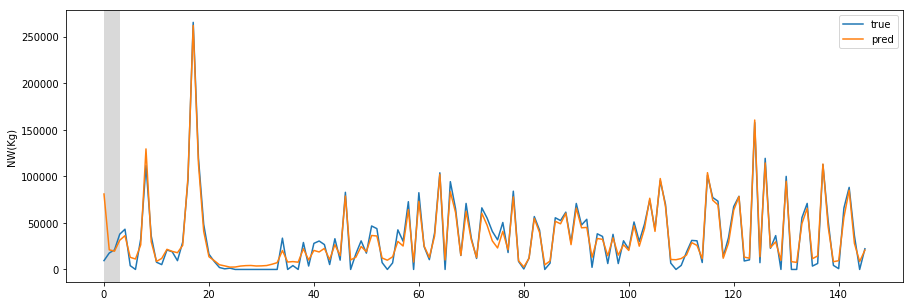

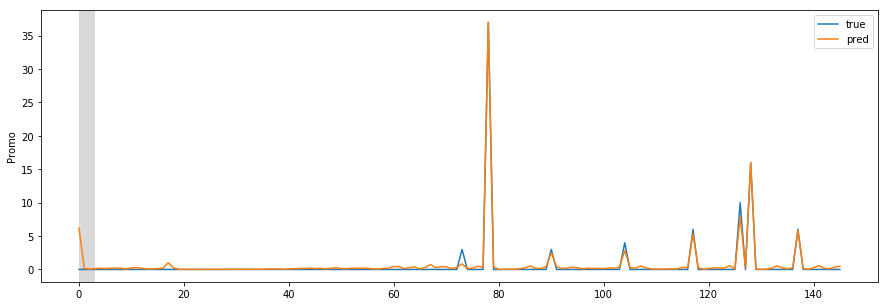

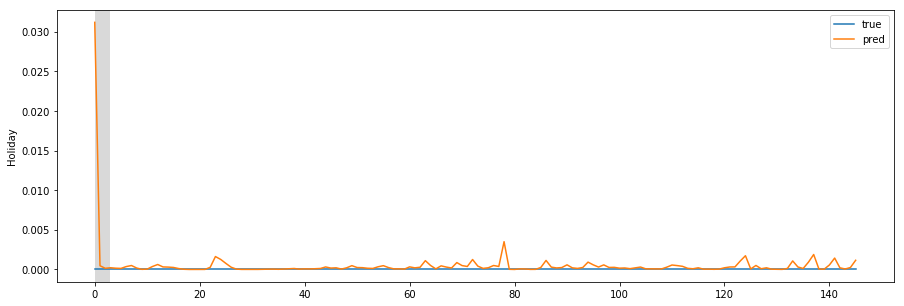

In [164]:
plot_comparison(start_idx=0, length=900, train=True)

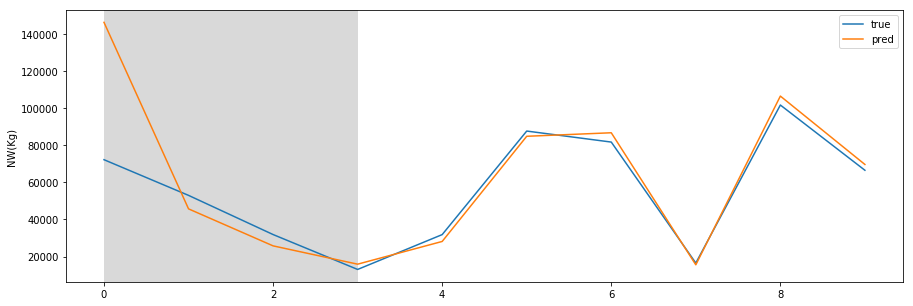

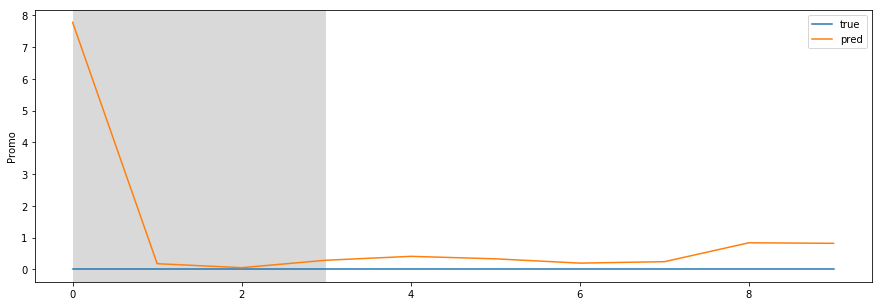

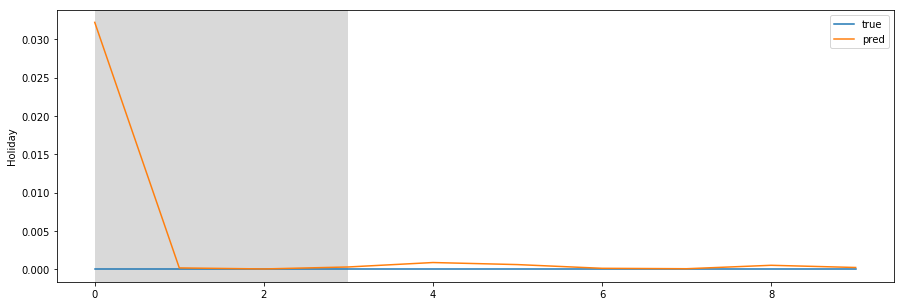

In [165]:
plot_comparison(start_idx=0, length=10, train=False)

In [ ]:
plot_comparison(start_idx=0, length=900, train=True)

In [ ]:
plot_comparison(start_idx=0, length=10, train=False)

In [ ]:
pd.DataFrame(true)

###############################################################################################################################

In [77]:
x2_asal = a2.tail(14).reset_index()
x2 = a2.tail(14)
coba = x2.values
coba_scaled = x_scaler.transform(coba)
print(coba_scaled.shape)
x = coba_scaled
x = np.expand_dims(x, axis=0)
y_pred = model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
hasil = pd.DataFrame(y_pred_rescaled)
hasil.columns = ['Pred_NW(Kg)','Pred_Promo','Pred_Holiday']

(14, 3)


In [78]:
hasil2 = hasil['Pred_NW(Kg)'].values
origin = a2.tail(14).reset_index()
asli = origin['NW(Kg)'].values

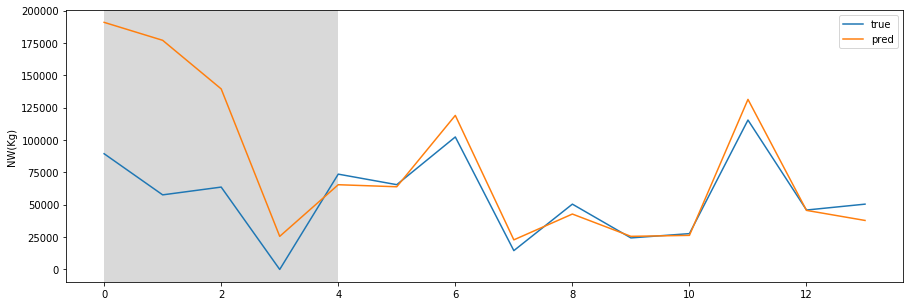

In [79]:
# Make the plotting-canvas bigger.
plt.figure(figsize=(15,5))
        
# Plot and compare the two signals.
plt.plot(asli, label='true')
plt.plot(hasil2, label='pred')
        
# Plot grey box for warmup-period.
p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
# Plot labels etc.
plt.ylabel('NW(Kg)')
plt.legend()
plt.show()